In [31]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cbcdb import DBManager
from scipy.stats import ttest_ind

In [32]:
db = DBManager(profile_name='pwa',
               secret_name='etl/config/env',
               region_name='us-east-1',
               use_aws_secrets=True)

#### Average revenue by invoice by day

In [47]:

sql = """
select
    network
   , date_part('dow', transaction_at) as appointment_dow
   , avg(revenue) as average_rev
   -- Contact and Vet Data
   --, product_is_medical
   from (
    select
    left(division_name,3) as network,
    transaction_at,
    invoice_id,
    sum(revenue) as revenue
    from dbt_prod_ezyvet.fct_transactions
   where appt_is_medical = 1
   and appointment_id is not null
   group by 1,2,3) x
   group by 1,2

         """

df = db.get_sql_dataframe(sql)
# df.to_csv('data/doctor_rev.csv', index=False)
df

/opt/anaconda3/envs/pwa/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,network,appointment_dow,average_rev
0,DFW,2.0,175.81
1,DFW,4.0,186.89
2,DAB,3.0,161.60
3,DAB,5.0,137.66
4,NYC,1.0,113.90
5,NYC,6.0,115.72
6,NYC,3.0,106.36
7,NYC,5.0,161.38
8,DFW,0.0,128.23
9,NSH,1.0,163.59


In [48]:
pd.pivot_table(df, index='network', columns=['appointment_dow'])

average_rev                                                
appointment_dow         0.0     1.0     2.0     3.0     4.0     5.0     6.0
network                                                                    
DAB                  125.30  159.45  163.23  161.60  152.87  137.66  145.65
DFW                  128.23  150.12  175.81  169.61  186.89  143.41  151.21
GVL                     NaN  143.13  157.36  145.50  131.95  142.55  115.50
KNX                     NaN  149.39  165.85  149.40  169.91  130.01  110.95
NSH                     NaN  163.59  183.16  184.57  208.88  153.04  148.97
NYC                     NaN  113.90  118.22  106.36  209.98  161.38  115.72

In [30]:

sql = """
with doctor_rev as (
select
division_name
, network_id
, appointment_at_date
, veterinarian
, count(distinct appointment_id) as appointment_count
, sum(first_appt) as first_appointment_count
, sum(revenue) as revenue
from (select
    division_name
   , network_id
   , date(revenue_at) as appointment_at_date
   -- Contact and Vet Data
   , veterinarian
   , appointment_id
   , first_appt
   --, product_is_medical
   , sum(revenue) as revenue
   from dbt_prod_ezyvet.fct_transactions
   where appt_is_medical = 1
   and appointment_id is not null
   group by 1,2,3,4,5,6) x
   group by 1,2,3,4)

   select
   a.*
   , d.appointment_count
   , d.first_appointment_count
   , d.revenue
     from dbt_prod_prod.fct_dr_avail_with_agg a
     join doctor_rev as d
      on a.division_name = d.division_name
        and  a.appointment_date = d.date
        and a.primary_resource_name = d.veterinarian
         """

df = db.get_sql_dataframe(sql)
df.to_csv('data/doctor_rev.csv', index=False)

/opt/anaconda3/envs/pwa/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


DatabaseError: Execution failed on sql '
with doctor_rev as (
select
division_name
, network_id
, appointment_at_date
, veterinarian
, count(distinct appointment_id) as appointment_count
, sum(first_appt) as first_appointment_count
, sum(revenue) as revenue
from (select
    division_name
   , network_id
   , date(revenue_at) as appointment_at_date
   -- Contact and Vet Data
   , veterinarian
   , appointment_id
   , first_appt
   --, product_is_medical
   , sum(revenue) as revenue
   from dbt_prod_ezyvet.fct_transactions
   where appt_is_medical = 1
   and appointment_id is not null
   group by 1,2,3,4,5,6) x
   group by 1,2,3,4)
   
   select
   a.*
   , d.appointment_count
   , d.first_appointment_count
   , d.revenue
     from dbt_prod_prod.fct_dr_avail_with_agg a
     join doctor_rev as d
      on a.division_name = d.division_name
        and  a.appointment_date = d.date
        and a.primary_resource_name = d.veterinarian
         ': column d.date does not exist


In [3]:
df = pd.read_csv('data/doctor_rev.csv')

#### Convert Data types

In [33]:
# Convert to date
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
# Identify weekday
df['appointment_date_weekday'] = df['appointment_date'].apply(lambda x: x.weekday())
# Free time proportion
df['doctor_utilization'] = df.apply(lambda x: 1 if x['free_time'] == 0 else 1 - (
        x['free_time'] / (x['free_time'] + x['minutes_in_office'] - x['block_minutes'])), axis=1)
# Revenue per minute
df['rev_per_min'] = df['revenue'] / (df['minutes_in_office'] - df['block_minutes'])
# Revenue per hour
df['rev_per_hour'] = df['rev_per_min'] * 60
# New appointment ratio
df['first_appt_ratio'] = df['first_appointment_count'] / df['appointment_count']
df['first_appt_ratio'].fillna(0, inplace=True)
# Network
df['network'] = df['division_name'].apply(lambda x: x[:3])

#### Filter

In [34]:
Q_25, Q_75, Q_90 = np.percentile(df['rev_per_hour'].dropna(), [25, 75, 90])
print(Q_75, Q_90)

114.8728535669587 155.59969281045753


In [35]:
df = df[(df.appointment_date > '2021-01-01') & (df.appointment_date < '2022-12-31')]
df = df[(df['rev_per_hour'] > 0) & (df['rev_per_hour'] < 99999)]

## EDA

In [36]:
df.groupby(['primary_resource_name','appointment_date'], as_index=False)['division_name'].count().sort_values('division_name', ascending=False)

,primary_resource_name,appointment_date,division_name
3830,Relief Vet,2022-08-08,5
3838,Relief Vet,2022-08-19,4
3835,Relief Vet,2022-08-15,4
3831,Relief Vet,2022-08-09,4
3833,Relief Vet,2022-08-11,4
...,...,...,...
1289,Dr. Donald Zuber,2021-10-11,1
1290,Dr. Donald Zuber,2021-10-12,1
1291,Dr. Donald Zuber,2021-10-14,1
1292,Dr. Donald Zuber,2021-10-15,1


In [37]:
df.corr()

,minutes_in_office,free_time,appt_duration_minutes_orig,appt_duration_minutes_,lunch_minutes,block_minutes,open_20_min_slots,open_40_min_slots,open_60_min_slots,holiday,fte_hours,primary_resource_active,appointment_count,first_appointment_count,revenue,appointment_date_weekday,doctor_utilization,rev_per_min,rev_per_hour,first_appt_ratio
minutes_in_office,1.000000,0.477110,0.289836,0.263565,0.445150,0.141841,0.126946,0.099858,0.067548,0.024127,-0.025565,0.178527,0.207993,0.112950,0.244840,-0.311747,-0.311760,-0.113203,-0.113203,-0.067720
free_time,0.477110,1.000000,-0.697011,-0.626860,0.326832,-0.248472,0.736238,0.716865,0.676609,0.013289,0.264473,0.106601,-0.444568,-0.312674,-0.349304,-0.186567,-0.909451,-0.568017,-0.568017,0.065967
appt_duration_minutes_orig,0.289836,-0.697011,1.000000,0.887748,0.006495,0.402887,-0.685720,-0.686681,-0.667318,0.004908,-0.288102,0.022796,0.642345,0.426430,0.568411,-0.055272,0.746151,0.523054,0.523054,-0.123341
appt_duration_minutes_,0.263565,-0.626860,0.887748,1.000000,-0.014354,-0.057429,-0.646358,-0.652765,-0.642580,0.004564,-0.343136,0.027296,0.739589,0.510551,0.658676,-0.028075,0.733173,0.528796,0.528796,-0.096850
lunch_minutes,0.445150,0.326832,0.006495,-0.014354,1.000000,0.054364,0.044273,0.037799,0.022543,0.008340,-0.006170,0.203067,0.038657,0.005934,0.044098,-0.184157,-0.259335,-0.114547,-0.114547,-0.036075
block_minutes,0.141841,-0.248472,0.402887,-0.057429,0.054364,1.000000,-0.205193,-0.195080,-0.176390,0.002367,0.063198,0.006946,-0.070371,-0.090595,-0.066731,-0.065537,0.132986,0.077020,0.077020,-0.084220
open_20_min_slots,0.126946,0.736238,-0.685720,-0.646358,0.044273,-0.205193,1.000000,0.982264,0.958103,0.003572,0.254215,-0.043927,-0.504755,-0.303815,-0.426239,-0.134613,-0.672669,-0.489654,-0.489654,0.166709
open_40_min_slots,0.099858,0.716865,-0.686681,-0.652765,0.037799,-0.195080,0.982264,1.000000,0.961067,0.008287,0.264088,-0.042428,-0.518954,-0.319183,-0.437651,-0.120097,-0.651736,-0.488148,-0.488148,0.160916
open_60_min_slots,0.067548,0.676609,-0.667318,-0.642580,0.022543,-0.176390,0.958103,0.961067,1.000000,-0.004906,0.292293,-0.048358,-0.518356,-0.317146,-0.441217,-0.106283,-0.606390,-0.473684,-0.473684,0.165730
holiday,0.024127,0.013289,0.004908,0.004564,0.008340,0.002367,0.003572,0.008287,-0.004906,1.000000,0.013478,0.005167,-0.005754,-0.034148,0.013447,0.024569,-0.005492,0.008916,0.008916,-0.038416


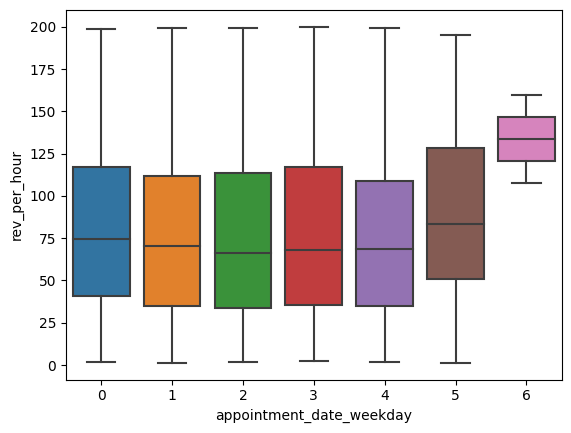

In [38]:
sns.boxplot(x=df['appointment_date_weekday'], y=df['rev_per_hour'])
plt.show()

### Explore outliers

In [39]:
df_outliers = df[df['rev_per_hour'] > 200]
sns.boxplot(x=df_outliers['appointment_date_weekday'], y=df_outliers['rev_per_hour'])
plt.show()

ValueError: min() arg is an empty sequence

#### Filter out outliers

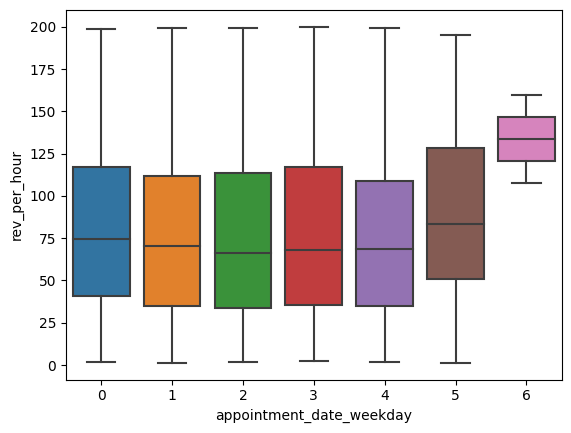

In [40]:
df = df[df['rev_per_hour'] <= 200]
sns.boxplot(x=df['appointment_date_weekday'], y=df['rev_per_hour'])
plt.show()

#### Initial EDA on  Doctor Utilization

In [42]:
### Doctor Utilization
df_work_proportion = df.groupby(['appointment_date_weekday', 'primary_resource_name'], as_index=False).agg(
    {'doctor_utilization': 'mean'}).dropna()
df.dropna(subset='doctor_utilization', inplace=True)
df.groupby('appointment_date_weekday', as_index=False).agg({'doctor_utilization': ['mean','count']})

appointment_date_weekday doctor_utilization      
                                         mean count
0                        0           0.693187   760
1                        1           0.683307   747
2                        2           0.676330   752
3                        3           0.692137   691
4                        4           0.704508   616
5                        5           0.785454   350
6                        6           1.000000     2

### Initial EDA on rev/hour

In [13]:
#### Average revenue by weekday
df_rev_wd = df.groupby(['appointment_date_weekday'], as_index=False).agg({'rev_per_hour': ['mean', 'count']}).dropna()
df_rev_wd

appointment_date_weekday rev_per_hour      
                                   mean count
0                        0    81.233673   760
1                        1    77.682873   747
2                        2    75.646604   752
3                        3    79.763201   691
4                        4    77.037254   616
5                        5    90.375107   350
6                        6   133.438462     2

#### In depth doctor utilization

##### Doctor Utilization Boxplot

In [14]:
color_palette = {5: ['blue', 'green', 'orange', 'red', 'purple'],
                 6: ['blue', 'green', 'orange', 'red', 'purple', 'yellow'],
                 7: ['blue', 'green', 'orange', 'red', 'purple', 'yellow', 'brown']}

0    161
3    148
2    146
1    127
4    116
5     42
6      1
Name: appointment_date_weekday, dtype: int64


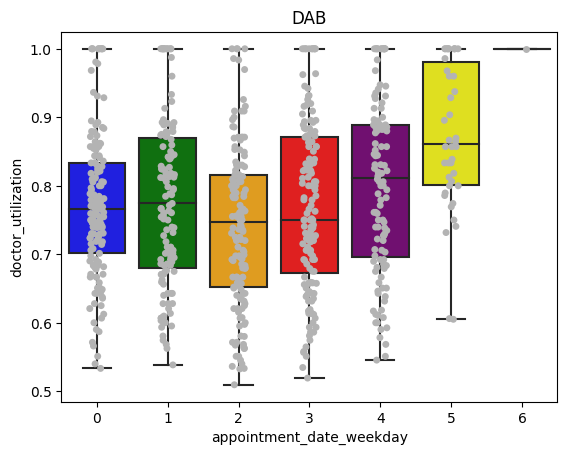

2    182
1    154
0    147
3    144
4    133
5     84
6      1
Name: appointment_date_weekday, dtype: int64


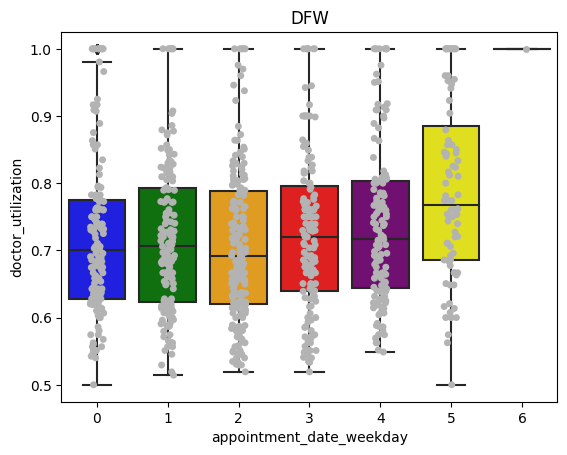

1    89
3    74
2    74
0    70
4    58
5    50
Name: appointment_date_weekday, dtype: int64


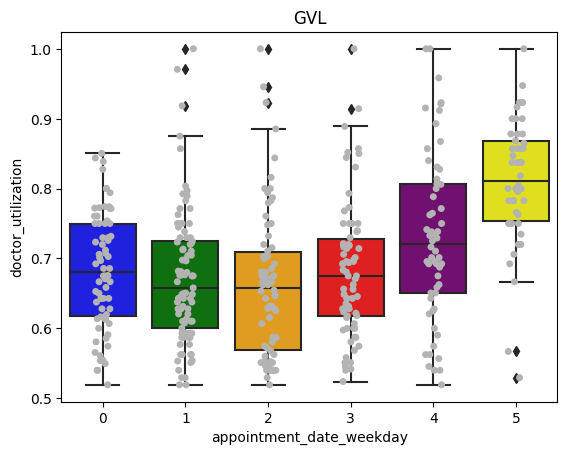

2    130
0    125
1    117
3    101
4     87
5     45
Name: appointment_date_weekday, dtype: int64


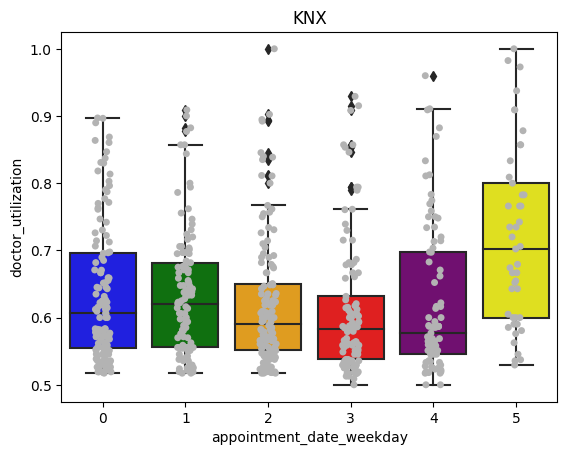

1    227
0    217
4    188
2    186
3    184
5     99
Name: appointment_date_weekday, dtype: int64


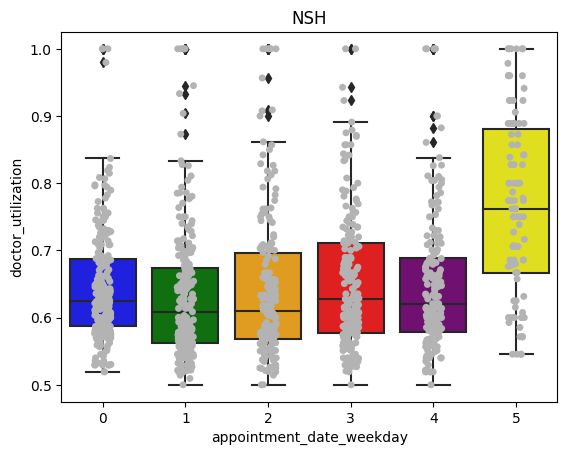

3    40
0    40
2    34
4    34
1    33
5    30
Name: appointment_date_weekday, dtype: int64


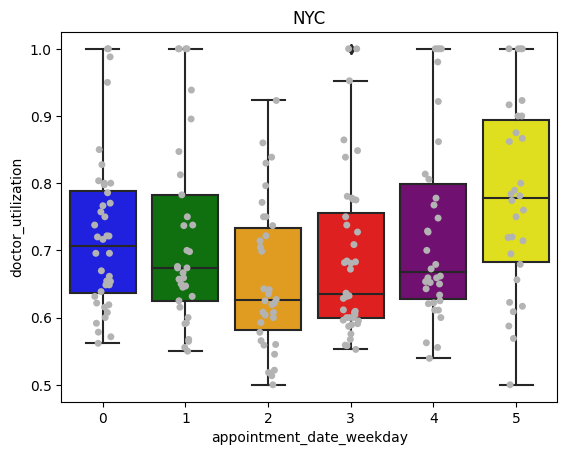

In [43]:
network = df.network.unique()
network.sort()
for d in network:
    df_temp = df[(df.network == d)].copy()
    palette = color_palette.get(len(df_temp.appointment_date_weekday.unique()))
    print(df_temp['appointment_date_weekday'].value_counts())

    sns.boxplot(data=df_temp, x='appointment_date_weekday', y='doctor_utilization', palette=palette).set_title(d)
    sns.stripplot(data=df_temp, x='appointment_date_weekday', y='doctor_utilization', color=".7").set_title(d)
    plt.show()

In [16]:
#### Doctor Utilization KDE Plot

for d in divisions:
    df_temp = df[(df.division_name == d)].copy()
    palette = color_palette.get(len(df_temp.appointment_date_weekday.unique()))
    print(df_temp['appointment_date_weekday'].value_counts())
    sns.kdeplot(data=df_temp, hue='appointment_date_weekday', x='rev_per_hour', palette=palette).set_title(d)
    plt.show()

#### Rev/Hour Boxplot

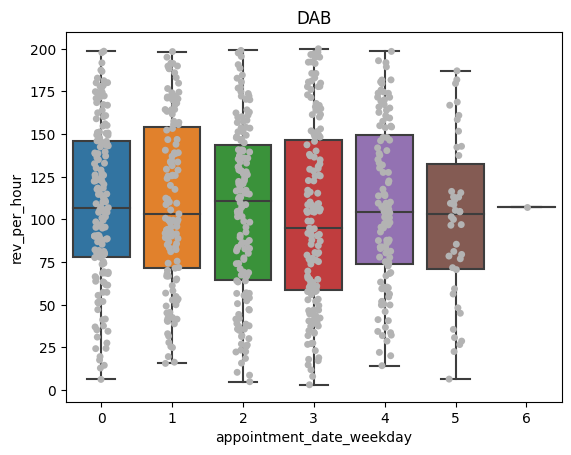

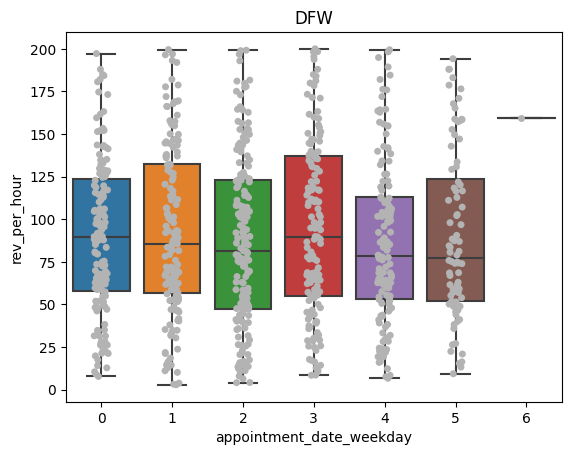

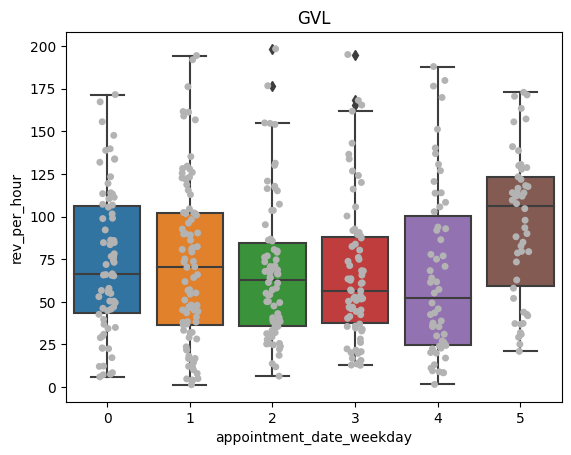

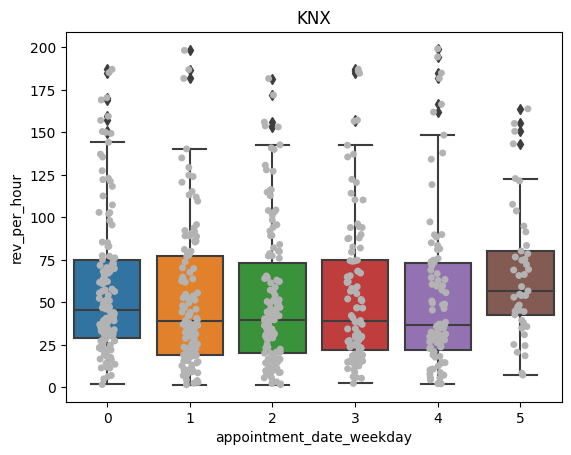

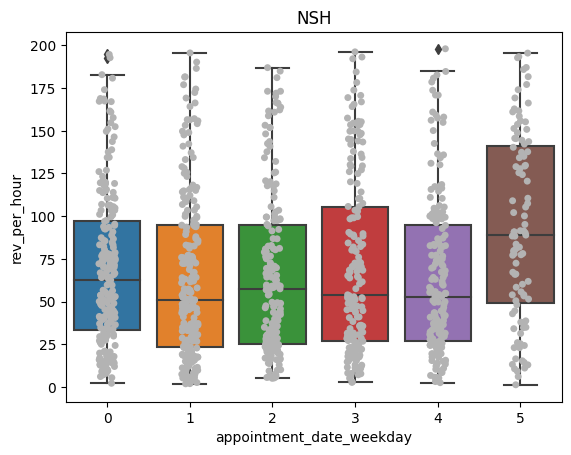

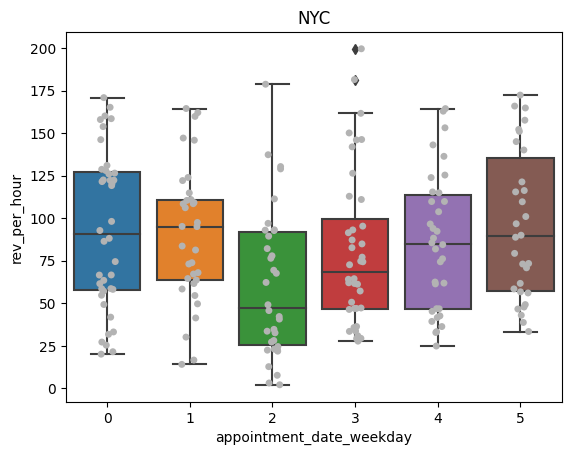

In [17]:
for d in network:
    df_temp = df[(df.network == d)].copy()
    sns.boxplot(data=df_temp, x='appointment_date_weekday', y='rev_per_hour').set_title(d)
    sns.stripplot(data=df_temp, x='appointment_date_weekday', y='rev_per_hour', color=".7").set_title(d)
    plt.show()

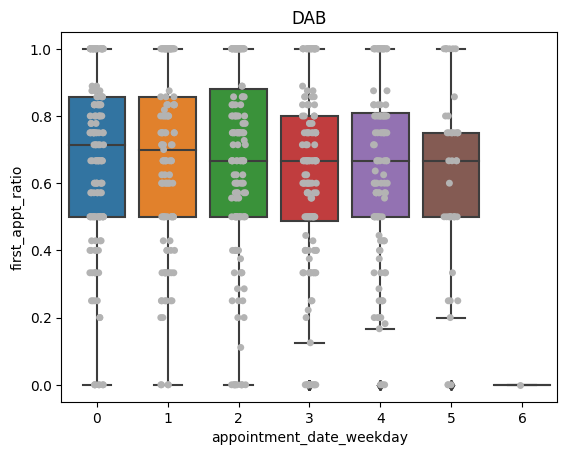

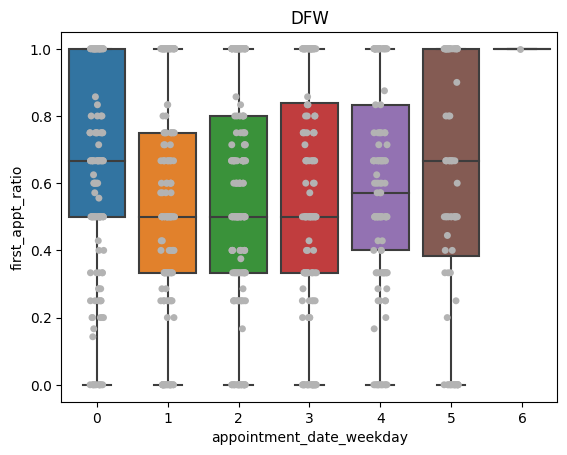

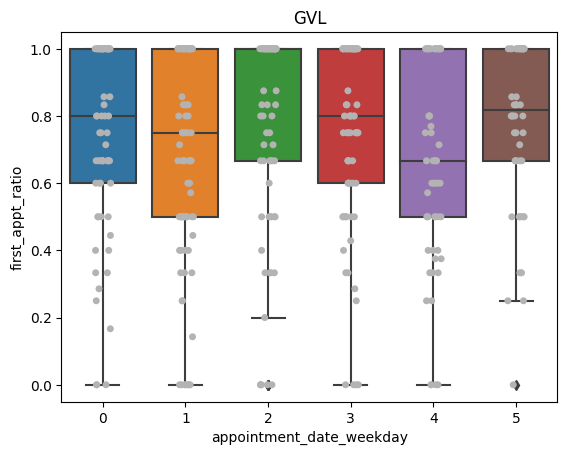

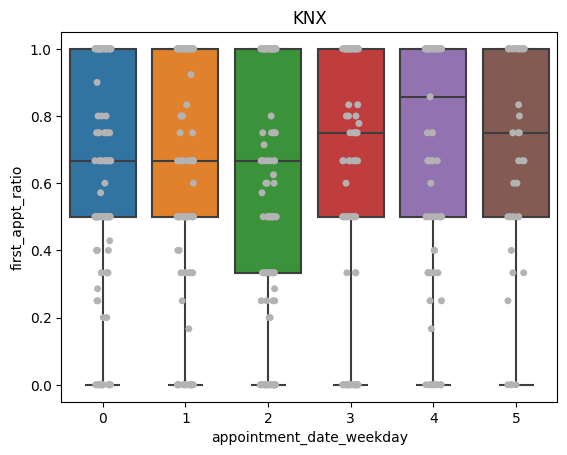

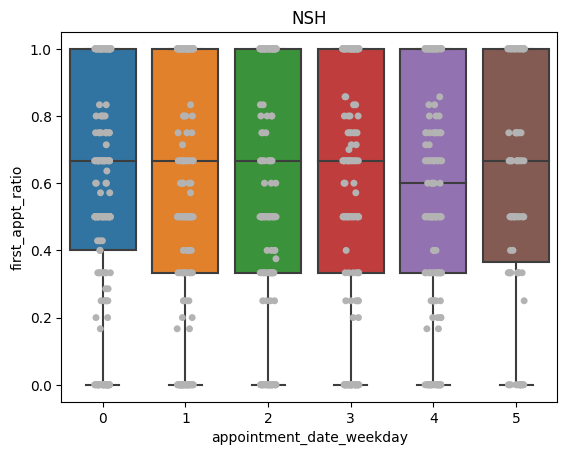

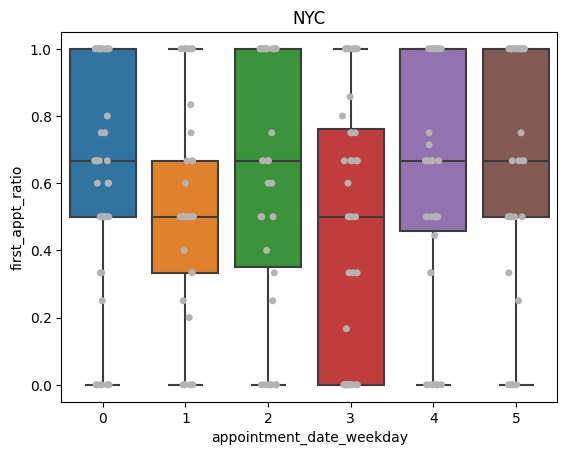

In [18]:
for d in network:
    df_temp = df[(df.network == d)].copy()
    sns.boxplot(data=df_temp, x='appointment_date_weekday', y='first_appt_ratio').set_title(d)
    sns.stripplot(data=df_temp, x='appointment_date_weekday', y='first_appt_ratio', color=".7").set_title(d)
    plt.show()


### Statistcal analysis

df_gkn = []
df_d = []
network = ['GVL', 'KNX', 'NSH']
for d in df_rev_wd_dc.division_name.unique():
    for n in network:
        if n in d:
            df_gkn.append(df[df.division_name == d])
        else:
            df_d.append(df[df.division_name == d])

df_gkn = pd.concat(df_gkn, ignore_index=True)
df_d = pd.concat(df_d, ignore_index=True)

In [19]:
df_gkn = []
df_d = []
network = ['GVL', 'KNX', 'NSH']
for d in df.division_name.unique():
    for n in network:
        if n in d:
            df_gkn.append(df[df.division_name == d])
        else:
            df_d.append(df[df.division_name == d])

df_gkn = pd.concat(df_gkn, ignore_index=True)
df_d = pd.concat(df_d, ignore_index=True)

In [20]:
df_gkn_5 = df_gkn[df_gkn['appointment_date_weekday'] == 5]
df_gkn_4 = df_gkn[df_gkn['appointment_date_weekday'] == 4]
df_gkn_3 = df_gkn[df_gkn['appointment_date_weekday'] == 3]
df_gkn_2 = df_gkn[df_gkn['appointment_date_weekday'] == 2]
df_gkn_1 = df_gkn[df_gkn['appointment_date_weekday'] == 1]
df_d_5 = df_d[df_d['appointment_date_weekday'] == 5]
df_d_1 = df_d[df_d['appointment_date_weekday'] == 1]


In [21]:
print(df_gkn_5.shape)
print(df_d_5.shape)

(194, 24)
(856, 24)


In [22]:
ttest_ind(df_d_5['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=0.8444284661378466, pvalue=0.3986227397854598)

In [23]:
ttest_ind(df_gkn_4['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=-6.010659269265091, pvalue=3.459937163479791e-09)

In [24]:
ttest_ind(df_gkn_3['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=-5.2940730649167085, pvalue=1.7304543548716495e-07)

In [25]:
ttest_ind(df_gkn_2['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=-6.525289878751804, pvalue=1.4771822592084091e-10)

In [26]:
ttest_ind(df_gkn_1['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=-6.2190086537791025, pvalue=9.156666924532099e-10)

In [27]:
ttest_ind(df_gkn_1['rev_per_hour'], df_gkn_5['rev_per_hour'])

Ttest_indResult(statistic=-6.2190086537791025, pvalue=9.156666924532099e-10)

### Linear Regression

In [28]:
df.head()

,division_name,primary_resource_name,minutes_in_office,appointment_date,free_time,appt_duration_minutes_orig,appt_duration_minutes_,lunch_minutes,block_minutes,open_20_min_slots,...,primary_resource_active,appointment_count,first_appointment_count,revenue,appointment_date_weekday,doctor_utilization,rev_per_min,rev_per_hour,first_appt_ratio,network
0,DAB010,Dr. Aric Krogstad,540,2022-06-29,130,410,410,60,0,3.0,...,1,6,4,1267.36,2,0.805970,2.346963,140.817778,0.666667,DAB
1,DAB010,Dr. Aric Krogstad,600,2022-03-31,100,500,500,60,0,5.0,...,1,7,6,1971.19,3,0.857143,3.285317,197.119000,0.857143,DAB
2,DAB010,Dr. Aric Krogstad,540,2021-12-30,30,510,490,60,20,0.0,...,1,7,3,903.29,3,0.945455,1.737096,104.225769,0.428571,DAB
3,DAB010,Dr. Aric Krogstad,600,2021-10-15,250,350,350,60,0,7.0,...,1,8,7,727.31,4,0.705882,1.212183,72.731000,0.875000,DAB
4,DAB010,Dr. Aric Krogstad,540,2021-10-29,0,540,440,60,100,3.0,...,1,3,2,490.89,4,0.000000,1.115659,66.939545,0.666667,DAB


In [29]:
features = 'division_name', 'minutes_in_office', 'free_time,'